### Algorithm for the analysis of the Medibio's ECG file set. 

###### written by Nicola Pastorello 19/0/2015

In [3]:
%matplotlib inline
# Loading libraries
import numpy as np
import pandas as pd
import datetime, pickle
import os, glob, sys
from pylab import *
from scipy import signal, misc



In [4]:
# Functions
def findCharPos(stringInput, c=' '):
    for ii in np.arange(len(stringInput)):
        if stringInput[ii] == c:
            return ii, stringInput[:ii]
    return False

def rollingMean(values, binSize=1):
    listMean = []
    for ii in np.arange(len(values)-binSize+1):
        listMean.append(np.mean(values[ii:ii+binSize]))
    return np.array(listMean)
    
def rollingStd(values, binSize=1):
    listStd = []
    for ii in np.arange(len(values)-binSize+1):
        listStd.append(np.std(values[ii:ii+binSize]))
    return np.array(listStd)
    
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area

def Gini(array):
    nn = len(array)
    array_sort = sort(array)
    frac_num, frac_den = 0., 0.
    for ii in np.arange(nn):
        frac_num += (nn+1-ii)*array_sort[ii]
        frac_den += array_sort[ii]
    return (nn+1-2.*frac_num/frac_den)/nn

def rollingGini(values, binSize=1):
    listStd = []
    for ii in np.arange(len(values)-binSize+1):
        listStd.append(Gini(values[ii:ii+binSize]))
    return np.array(listStd)


def rollingGaussian(values, binSize=1):
    w = signal.gaussian(len(values), binSize)
    #
    convolvedProf = np.convolve(values, w, mode='same')
    #
    normConvProf = convolvedProf/np.median(convolvedProf)
    normProf = values/np.median(values)
    return normProf-normConvProf


 




In [5]:
# Extract input
fileIn = open('dicDF.dat', 'rb')
dicDF = pickle.load(fileIn)
fileIn.close()

# Extracting time in minutes
mm = []
for jj in dicDF[dicDF.keys()[0]]['time']:
    mm.append(jj.hours*60.+jj.minutes)
    
mm = np.array(mm)

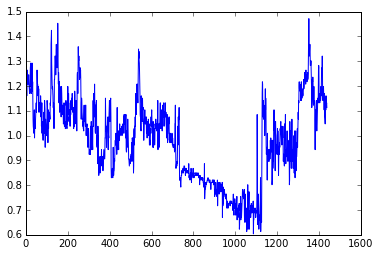

In [6]:
# Example of data
index = np.random.randint(0, len(dicDF))
keyDic = dicDF.keys()[index]
try:
    plot(mm, dicDF[keyDic]['hb']/np.median(dicDF[keyDic]['hb']))
except:
    plot(mm[:-1], dicDF[keyDic]['hb']/np.median(dicDF[keyDic]['hb']))

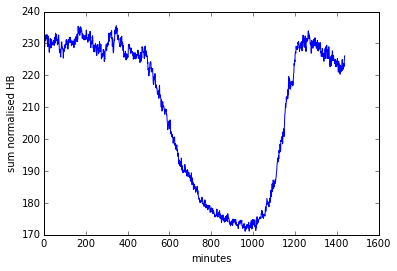

In [7]:
# Summing profiles to extract sleep time window
totProfiles = np.zeros(len(dicDF[dicDF.keys()[0]])-1)
for ii in dicDF.keys():
    if len(dicDF[ii]) != len(totProfiles): 
        totProfiles += dicDF[ii]['hb'][:-1]/np.median(dicDF[ii]['hb'][:-1])
    else:
        totProfiles += dicDF[ii]['hb']/np.median(dicDF[ii]['hb'])

plot(mm[:-1], totProfiles)
xlabel('minutes'); ylabel('sum normalised HB')

selSleep = np.where((mm>600) & (mm<1080))

### For each profile, extract different stats and create dataframe with them. 


STD_gini: 0.0419227173973
STD_Gaussian: 0.101399869643


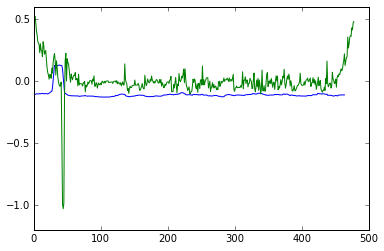

In [8]:
### Comparison between STD_Gini and STD_Gaussian_convolution

dfTmp = dicDF[dicDF.keys()[207]]   # Outliers: 29,  39,  55, 120, 207
binSize = 15
rGini = rollingGini(dfTmp['hb'][selSleep[0]], binSize=binSize)

print 'STD_gini:',std(rGini)
#plot(dfTmp['hb'][selSleep[0]])
plot(rGini, c='b')

rGaussian = rollingGaussian(dfTmp['hb'][selSleep[0]], binSize=binSize)
plot(rGaussian, c='g')
print 'STD_Gaussian:', std(rGaussian[binSize:-binSize]) #Removing wings

#plot(dfTmp['hb'][selSleep[0]])

In [72]:
listGinistd, listConvstd = [], []
listGiniProf, listConvProf = [], []

for ii in dicDF.keys():
    dfTmp = dicDF[ii]    

    # Rolling Gini coefficient -> std
    binSize = 10

    rGini = rollingGini(dfTmp['hb'][selSleep[0]], binSize=binSize)
    #plot(mm[selSleep][:-binSize+1], rGini, c='r')
    #print std(rGini)
    
    listGinistd.append(np.std(rGini))
    listGiniProf.append(rGini)
    
    # Gaussian smoothed signal 
    # I save the standard deviation of the difference between original and
    # smoothed (thus excluding larger scale variations)
    sigmaGaussian = 10. #In minutes
    rGaussian = rollingGaussian(dfTmp['hb'][selSleep[0]], binSize=sigmaGaussian)
    listConvstd.append(std(rGaussian[binSize:-binSize]))
    listConvProf.append(rGaussian[binSize:-binSize])
    
seriesGiniStd = pd.Series(listGinistd)
seriesConvStd = pd.Series(listConvstd)
seriesGiniProf = pd.Series(listGiniProf)
seriesConvProf = pd.Series(listConvProf)
seriesID = pd.Series(dicDF.keys())

dic_coeff = {'ID':seriesID, 'Gini': seriesGiniStd, 'Conv': seriesConvStd)
                             #, 'GiniProf': seriesGiniProf, 'ConvProf': seriesConvProf}
df_coeff = pd.DataFrame(dic_coeff)
             
     


In [74]:
# Finding outliers in relation
selOutliers = np.where(dic_coeff['Gini'] > 0.04)
print selOutliers
print dic_coeff['Gini'][selOutliers[0]]
print dic_coeff['Conv'][selOutliers[0]]

(array([ 29,  39,  55, 120, 207]),)
29     0.096409
39     0.103237
55     0.078504
120    0.058771
207    0.047161
dtype: float64
29     0.205021
39     0.119646
55     0.092257
120    0.151991
207    0.093856
dtype: float64


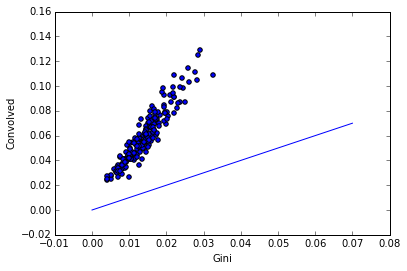

In [133]:
#scatter(dic_coeff['Gini'], dic_coeff['Conv']) #Total
selInliers = np.where(dic_coeff['Gini'] <= 0.04) #Cleaned
scatter(dic_coeff['Gini'][selInliers[0]], dic_coeff['Conv'][selInliers[0]])
plot([0,0.07],[0,.07])
xlabel('Gini'); ylabel('Convolved')

# Removing outliers
df_coeff_clean = df_coeff[df_coeff.Gini <=0.04]

In [131]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Save dataframe as a .csv file with rpy2
# (it works only if each field has a single value (not arrays))

## get a reference to the R function 
write_csv = robjects.r('write.csv')
## save 
write_csv(df_coeff_clean,'dataframe.csv')

# Save dataframe as a Rdata file with rpy2
r_dataframe = pandas2ri.py2ri(df_coeff_clean) 
robjects.globalenv['DF'] = r_dataframe
robjects.r('save(DF, file="dataframe.Rdata")')

# Save dataframe as a pickle object
fileOut = open('dataframe.dat', 'wb')
pickle.dump(df_coeff_clean, fileOut)
fileOut.close()


# Save series of rolling Gini profiles as .csv
write_csv = robjects.r('write.csv')
write_csv(seriesConvProf,'rGiniprof.csv')

# Save series of rolling Gini profile as R matrix
robjects.globalenv['GiniProfMatrix'] = np.array(matrix(listGiniProf))
robjects.r('save(GiniProfMatrix, file="matrix.Rdata")')

rpy2.rinterface.NULL

###### Trash/Experimental stuff

(-1.4, 1.4)

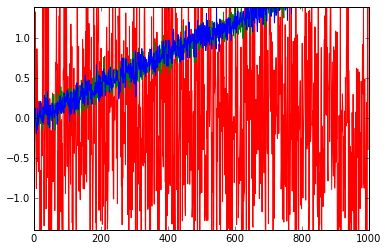

In [167]:
# Check whether rollling Gini is able to discern profiles with different GLOBAL trends

# Create profiles
profileNormal = np.random.randn(1000)
profileUp = +0.02*np.arange(1000)+np.random.randn(1000)
profileDown = -0.02*np.arange(1000)+np.random.randn(1000)

profileUp /= np.median(profileUp)
profileDown /=  np.median(profileDown)
#rollingGini

plot(profileNormal, c='r')
plot(profileDown, c='g')
plot(profileUp, c='b')

ylim(-1.4, 1.4)

(2.1989855648322449, 1.9493361080561791, -1.4812067492152361)

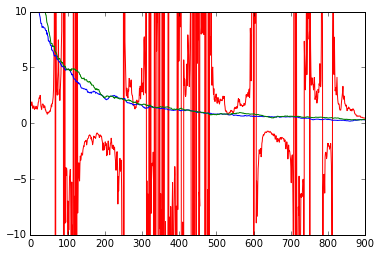

In [168]:
# Creating rolling Gini profiles
rG_normal = rollingGini(profileNormal,binSize=100)
rG_up = rollingGini(profileUp,binSize=100)
rG_down = rollingGini(profileDown,binSize=100)

plot(rG_normal/np.median(rG_normal), c='r')
plot(rG_up/np.median(rG_up), c='b')
plot(rG_down/np.median(rG_down), c='g')
ylim(-10,10)

mean(rG_down/np.median(rG_down)), mean(rG_up/np.median(rG_up)), mean(rG_normal/np.median(rG_normal))

478 3.5


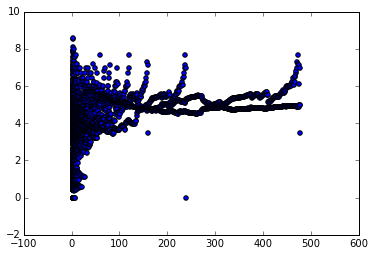

In [65]:
# Try to estimate the Hurst coefficient for a single profile
dfTmp = dicDF[dicDF.keys()[4]]
#plot(mm, dfTmp['hb'])
#plot(mm[selSleep[0]], dfTmp['hb'][selSleep[0]])

# Measuring the standard deviation at different scales
yy = np.array(dfTmp['hb'][selSleep[0]])
std_values, window_size = [], []

for ss in np.arange(2, len(yy)): # Different time windows, from 2 minutes to whole extent of the sleep window
    for window_index0 in np.arange(0, len(yy), ss-1):
        std_values.append(np.std(yy[window_index0:window_index0+ss+1]))
        window_size.append(ss)


scatter(window_size, std_values)
print window_size[-1], std_values[-1]


In [ ]:
# Measuring the signal profile (SP, Hardstone+12, Eqn. 2)
# Scaling analysis on this makes no a priori assumptions on the stationarity of the profile. 
# If the estimated H is 0<H<1, the SP is from a stationary process. If 1<H<2, SP is from a non-stationary process.
yy = np.array(dfTmp['hb'][selSleep[0]])

SF = np.zeros(len(yy))
for ii in np.arange(len(yy)):
    tmpValue = 0
    for jj in np.arange(ii):
        tmpValue += yy[jj]
    SF[ii] = tmpValue - np.mean(yy)

plot(SF)



In [190]:

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects.packages import importr

base = importr('base')
# call an R function on a Pandas DataFrame
base.summary(df_coeff)



<Matrix - Python:0x117da5680 / R:0x117e46a80>
[str, str, str, ..., str, str, str]

In [166]:
# Run K-means clustering on the series
from sklearn.cluster import KMeans
from sklearn import datasets
np.random.seed(5)

cluster.Kmeans(n_clusters=2, n_init=10, )

AttributeError: 'module' object has no attribute 'Kmeans'

In [165]:

iris = datasets.load_iris()

NameError: name 'datasets' is not defined

0.101802728322


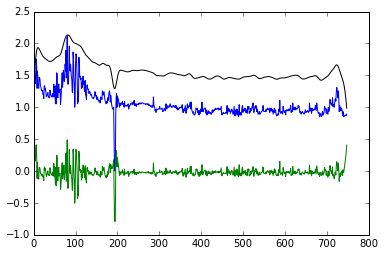

In [159]:
normConvProf = convolvedProf/np.median(convolvedProf)
normProf = dfTmp['hb'][selSleep[0]]/np.median(dfTmp['hb'][selSleep[0]])
plot(normConvProf+0.5, 'k')
plot(normProf)
print np.std(normProf-normConvProf)
plot(normProf-normConvProf)

IndexError: index 720 is out of bounds for axis 1 with size 720

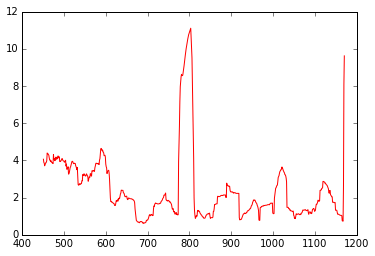

In [136]:
dfTmp = dicDF[dicDF.keys()[0]]

# Rolling mean
binSize = 30 # A hour bin

# plot(mm[:-binSize+1], 
#      dfTmp['hb'][:-binSize+1]-rollingMean(dfTmp['hb'], binSize=binSize), 
#      color='k')
# plot(mm, dfTmp['hb'])

rStd = rollingStd(dfTmp['hb'][selSleep[0]], binSize=binSize)

plot(mm[selSleep][:-binSize+1], rStd, c='r')

print mean(rStd[selSleep])

0.0125694762918


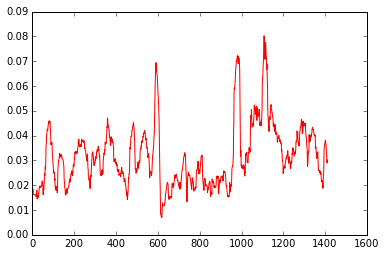

In [72]:
rGini = rollingGini(dfTmp['hb'], binSize=binSize)
plot(mm[:-binSize+1], rGini, c='r')

print std(rGini)

0.0490427912628


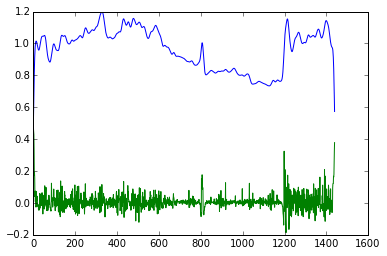

In [66]:
# Try convolving the signal with a Gaussian

from scipy import signal, misc
sigmaGaussian = 5 #In minutes
w = signal.gaussian(len(dfTmp['hb']), sigmaGaussian)

convolvedProf = np.convolve(dfTmp['hb'], w, mode='same')

normConvProf = convolvedProf/np.median(convolvedProf)
plot(normConvProf, c='b')

normProf = dfTmp['hb']/np.median(dfTmp['hb'])
# plot(normProf, c='k')

plot(mm, normProf-normConvProf)

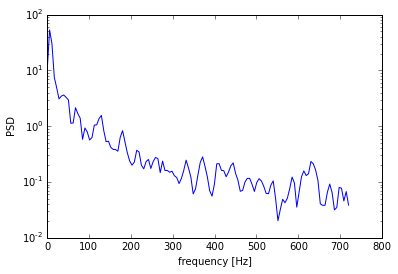

In [27]:
# Welch's method to estimate the power at different frequencies
f, Pwelch_spec = signal.welch(dfTmp['hb'], len(dfTmp['hb']), scaling='spectrum')
plt.semilogy(f, Pwelch_spec)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
 

In [326]:

print Gini(np.random.random(1e3))

'''
# Experiments with rolling Gini
valuesGini = []
for ii in np.arange(1e3):
    aa = np.random.randn(1e2)
    raa = rollingGini(aa, binSize=binSize)
    valuesGini.append(np.std(raa))
#plot(raa)
#print np.mean(raa), np.std(raa)
'''


0.344201134001


'\n# Experiments with rolling Gini\nvaluesGini = []\nfor ii in np.arange(1e3):\n    aa = np.random.randn(1e2)\n    raa = rollingGini(aa, binSize=binSize)\n    valuesGini.append(np.std(raa))\n#plot(raa)\n#print np.mean(raa), np.std(raa)\n'

In [229]:
a=np.array([1,2,5,3])
sort(a)


array([1, 2, 3, 5])